# Vehicle Damage Detection Project

## Import Libraries

In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,random_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Load Data

In [3]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
dataset_path = "./dataset"
dataset = datasets.ImageFolder(root=dataset_path,transform=image_transforms)
len(dataset)

2300

In [5]:
2300 * 0.75

1725.0

In [6]:
class_names = dataset.classes
class_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [7]:
num_classes = len(dataset.classes)
num_classes

6

In [8]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(1725, 575)

In [9]:
train_dataset, val_dataset = random_split(dataset,[train_size,val_size])

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [11]:
for images,labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [12]:
labels[1]

tensor(5)

In [13]:
images[1].shape

torch.Size([3, 224, 224])

In [14]:
images[1].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..1.6988237].


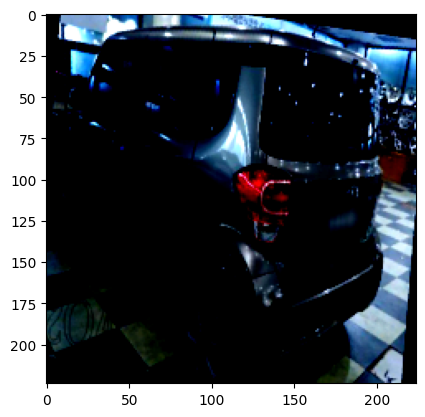

In [15]:
plt.imshow(images[1].permute(1,2,0))
plt.show()

## Models

### Model 1: CNN

In [16]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [17]:
images.size(0)

32

In [18]:
len(train_loader.dataset)

1725

In [19]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

In [20]:
# Instantiate the model, loss function, and optimizer
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.76
Batch: 20, Epoch: 1, Loss: 1.73
Batch: 30, Epoch: 1, Loss: 1.81
Batch: 40, Epoch: 1, Loss: 1.50
Batch: 50, Epoch: 1, Loss: 1.53
Epoch [1/10], Avg Loss: 1.8583
*** Validation Accuracy: 41.39% ***
Batch: 10, Epoch: 2, Loss: 1.36
Batch: 20, Epoch: 2, Loss: 1.15
Batch: 30, Epoch: 2, Loss: 1.40
Batch: 40, Epoch: 2, Loss: 1.24
Batch: 50, Epoch: 2, Loss: 1.46
Epoch [2/10], Avg Loss: 1.3401
*** Validation Accuracy: 52.70% ***
Batch: 10, Epoch: 3, Loss: 1.52
Batch: 20, Epoch: 3, Loss: 1.10
Batch: 30, Epoch: 3, Loss: 1.29
Batch: 40, Epoch: 3, Loss: 1.23
Batch: 50, Epoch: 3, Loss: 1.24
Epoch [3/10], Avg Loss: 1.1442
*** Validation Accuracy: 50.96% ***
Batch: 10, Epoch: 4, Loss: 1.00
Batch: 20, Epoch: 4, Loss: 0.95
Batch: 30, Epoch: 4, Loss: 0.99
Batch: 40, Epoch: 4, Loss: 1.31
Batch: 50, Epoch: 4, Loss: 1.06
Epoch [4/10], Avg Loss: 1.0311
*** Validation Accuracy: 56.35% ***
Batch: 10, Epoch: 5, Loss: 1.01
Batch: 20, Epoch: 5, Loss: 0.97
Batch: 30, Epoch: 5, Loss: 0

### Model 2: CNN with Regularization

In [21]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [22]:
model = CarClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

all_labels, all_predictions = train_model(model, criterion, optimizer,  epochs=10)

Batch: 10, Epoch: 1, Loss: 9.44
Batch: 20, Epoch: 1, Loss: 5.45
Batch: 30, Epoch: 1, Loss: 1.71
Batch: 40, Epoch: 1, Loss: 1.62
Batch: 50, Epoch: 1, Loss: 1.64
Epoch [1/10], Avg Loss: 7.4133
*** Validation Accuracy: 40.35% ***
Batch: 10, Epoch: 2, Loss: 1.42
Batch: 20, Epoch: 2, Loss: 1.42
Batch: 30, Epoch: 2, Loss: 1.44
Batch: 40, Epoch: 2, Loss: 1.27
Batch: 50, Epoch: 2, Loss: 1.23
Epoch [2/10], Avg Loss: 1.4115
*** Validation Accuracy: 46.61% ***
Batch: 10, Epoch: 3, Loss: 1.30
Batch: 20, Epoch: 3, Loss: 1.26
Batch: 30, Epoch: 3, Loss: 1.17
Batch: 40, Epoch: 3, Loss: 1.21
Batch: 50, Epoch: 3, Loss: 1.16
Epoch [3/10], Avg Loss: 1.3018
*** Validation Accuracy: 44.87% ***
Batch: 10, Epoch: 4, Loss: 1.39
Batch: 20, Epoch: 4, Loss: 1.39
Batch: 30, Epoch: 4, Loss: 1.29
Batch: 40, Epoch: 4, Loss: 1.14
Batch: 50, Epoch: 4, Loss: 1.37
Epoch [4/10], Avg Loss: 1.2390
*** Validation Accuracy: 49.91% ***
Batch: 10, Epoch: 5, Loss: 1.13
Batch: 20, Epoch: 5, Loss: 1.18
Batch: 30, Epoch: 5, Loss: 1

### Model 3: Transfer Learning with EfficientNet

In [23]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

1280

In [24]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x              

In [25]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.72
Batch: 20, Epoch: 1, Loss: 1.46
Batch: 30, Epoch: 1, Loss: 1.41
Batch: 40, Epoch: 1, Loss: 1.37
Batch: 50, Epoch: 1, Loss: 1.20
Epoch [1/10], Avg Loss: 1.4851
*** Validation Accuracy: 60.87% ***
Batch: 10, Epoch: 2, Loss: 1.14
Batch: 20, Epoch: 2, Loss: 1.36
Batch: 30, Epoch: 2, Loss: 1.20
Batch: 40, Epoch: 2, Loss: 1.08
Batch: 50, Epoch: 2, Loss: 0.97
Epoch [2/10], Avg Loss: 1.1408
*** Validation Accuracy: 63.83% ***
Batch: 10, Epoch: 3, Loss: 1.21
Batch: 20, Epoch: 3, Loss: 1.06
Batch: 30, Epoch: 3, Loss: 1.29
Batch: 40, Epoch: 3, Loss: 0.85
Batch: 50, Epoch: 3, Loss: 1.05
Epoch [3/10], Avg Loss: 1.0406
*** Validation Accuracy: 65.39% ***
Batch: 10, Epoch: 4, Loss: 1.15
Batch: 20, Epoch: 4, Loss: 0.99
Batch: 30, Epoch: 4, Loss: 0.93
Batch: 40, Epoch: 4, Loss: 0.97
Batch: 50, Epoch: 4, Loss: 1.12
Epoch [4/10], Avg Loss: 0.9688
*** Validation Accuracy: 68.35% ***
Batch: 10, Epoch: 5, Loss: 1.18
Batch: 20, Epoch: 5, Loss: 0.99
Batch: 30, Epoch: 5, Loss: 0

### Model 4: Transfer Learning with ResNet

In [26]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [27]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.06
Batch: 20, Epoch: 1, Loss: 0.94
Batch: 30, Epoch: 1, Loss: 0.74
Batch: 40, Epoch: 1, Loss: 0.79
Batch: 50, Epoch: 1, Loss: 0.61
Epoch [1/10], Avg Loss: 0.9057
*** Validation Accuracy: 76.17% ***
Batch: 10, Epoch: 2, Loss: 0.60
Batch: 20, Epoch: 2, Loss: 0.55
Batch: 30, Epoch: 2, Loss: 0.41
Batch: 40, Epoch: 2, Loss: 0.71
Batch: 50, Epoch: 2, Loss: 0.40
Epoch [2/10], Avg Loss: 0.5062
*** Validation Accuracy: 71.48% ***
Batch: 10, Epoch: 3, Loss: 0.28
Batch: 20, Epoch: 3, Loss: 0.49
Batch: 30, Epoch: 3, Loss: 0.30
Batch: 40, Epoch: 3, Loss: 0.45
Batch: 50, Epoch: 3, Loss: 0.30
Epoch [3/10], Avg Loss: 0.3891
*** Validation Accuracy: 71.30% ***
Batch: 10, Epoch: 4, Loss: 0.31
Batch: 20, Epoch: 4, Loss: 0.27
Batch: 30, Epoch: 4, Loss: 0.15
Batch: 40, Epoch: 4, Loss: 0.19
Batch: 50, Epoch: 4, Loss: 0.23
Epoch [4/10], Avg Loss: 0.2561
*** Validation Accuracy: 80.52% ***
Batch: 10, Epoch: 5, Loss: 0.17
Batch: 20, Epoch: 5, Loss: 0.19
Batch: 30, Epoch: 5, Loss: 0

### Model Evaluation using Confusion Matrix and Classification Report

In [28]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       129
           1       0.72      0.91      0.80        85
           2       0.96      0.88      0.92       135
           3       0.82      0.69      0.75        67
           4       0.69      0.65      0.67        88
           5       0.72      0.87      0.79        71

    accuracy                           0.82       575
   macro avg       0.81      0.81      0.81       575
weighted avg       0.83      0.82      0.83       575



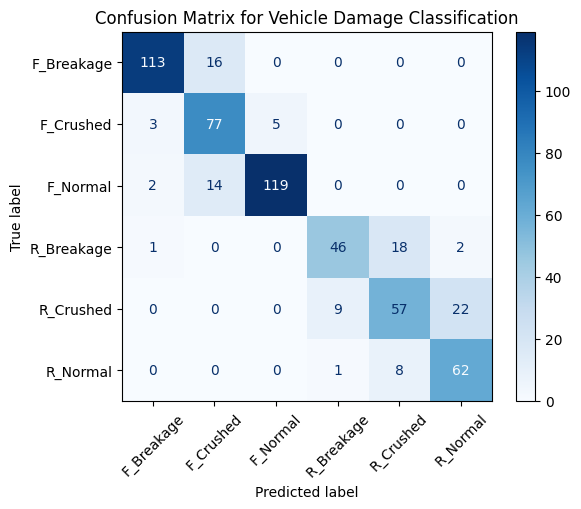

In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

### Save the Model

In [30]:
torch.save(model.state_dict(), 'saved_model.pth')